In [1]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

In [2]:
# Define filepath
filepath = '/Users/zenon/Documents/Lab4_Data/lab4/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\LC08_L2SP_047029_20200814_20210330_02_T1_SR_B7.tif', '/Users/zenon/Documents/Lab4_Data/lab4/landsat\\rgb.tif']


In [3]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1)

In [4]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


In [5]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [6]:
# Find format
src.driver

'GTiff'

In [7]:
# Find pixel size
src.transform[0]

30.0

In [8]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

In [9]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


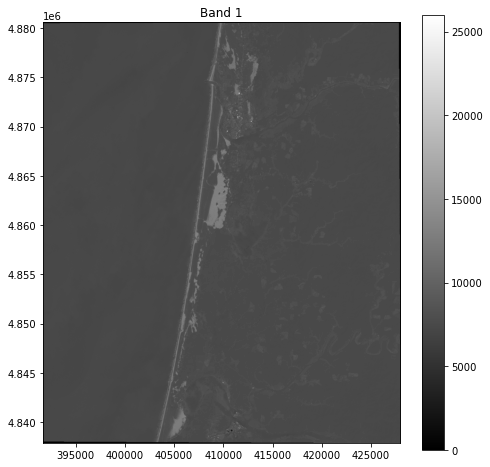

In [10]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

In [11]:
# Find number of columns and rows in array
band_1.shape

(1422, 1208)

In [12]:
# Find total number of pixels in array
band_1.size

1717776

In [13]:
# Find maximum value in array
band_1.max()

25983

In [14]:
# Find datatype
band_1.dtype

dtype('uint16')

In [15]:
# Find maximum possible value in array
2**16

65536

In [16]:
# Find file size (in MB)
band_1.nbytes / 1000000

3.435552

In [17]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [18]:
all_bands.shape

(1422, 1208, 8)

In [19]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [20]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

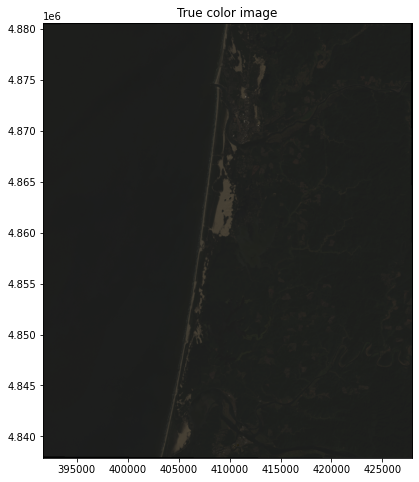

In [21]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()

In [22]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

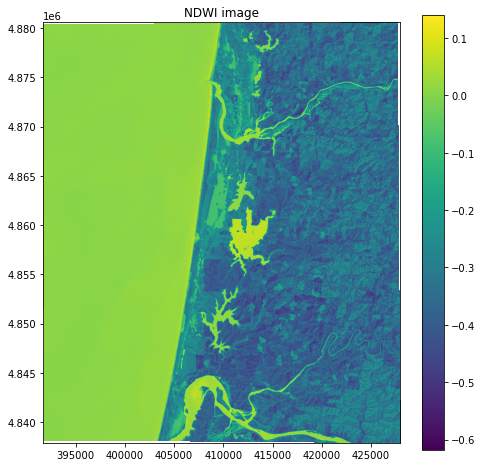

In [23]:
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [24]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [25]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

CPLE_AppDefinedError: Deleting /Users/zenon/Documents/Lab4_Data/lab4/landsat/rgb.tif failed: Permission denied

In [26]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [27]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 233, latitude: 99, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-05 17:55:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

In [28]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


In [29]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

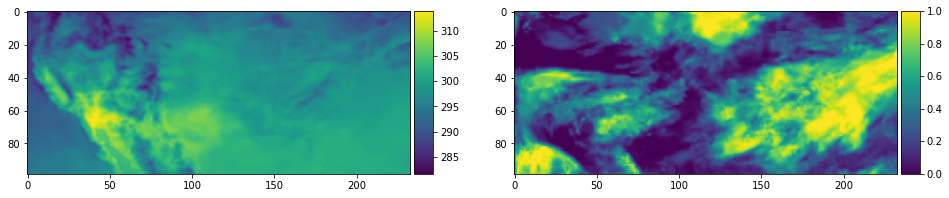

In [30]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

In [31]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

C:\Users\zenon\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\zenon\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [32]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [33]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.25 F


Text(0, 0.5, 'Cloud cover (%)')

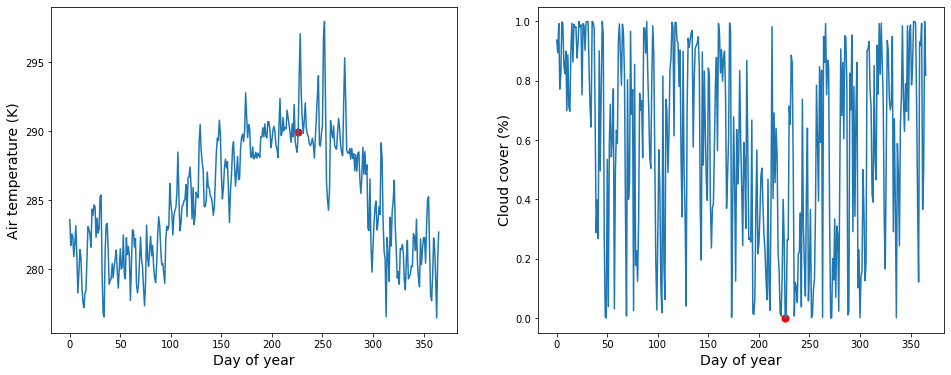

In [34]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

In [35]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.55 F


In [36]:
mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean cloud cover in Florence in 2020 = 58.76 %


In [37]:
days = np.sum(florence_weather['tcc'] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 61 days with less than 20% cloud cover in 2020



# Answers for Question 1 a and b follow below


In [38]:
fahrenheit = (florence_weather['t2m'][31].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Jan 31, 2020 = %.2f F' % (fahrenheit))

# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Jan 31, 2020 = %.2f %%' % (florence_weather['tcc'][31].values * 100))

Air temperature in Florence on Jan 31, 2020 = 54.04 F
Cloud cover in Florence on Jan 31, 2020 = 99.88 %


In [39]:
# Next, find the index of the grid point nearest a specific lat/lon.   
eugene_weather = xds_daily.sel(latitude=44.06033352909395, longitude=-123.10255869313659, method='nearest')

C:\Users\zenon\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\zenon\anaconda3\envs\lab4\lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(


In [40]:
fahrenheit = (eugene_weather['t2m'][46].values - 273.15) * 9/5 + 32
print('Air temperature in Eugene on Feb 15, 2020 = %.2f F' % (fahrenheit))

# Note: Aug 14 is DOY 226
print('Cloud cover in Eugene on Feb 15, 2020 = %.2f %%' % (eugene_weather['tcc'][46].values * 100))

Air temperature in Eugene on Feb 15, 2020 = 43.79 F
Cloud cover in Eugene on Feb 15, 2020 = 97.51 %




# Answers for Question 2 a through f follow below



In [41]:
help(xarray.DataArray.mean)

Help on function mean in module xarray.core.common:

mean(self, dim=None, axis=None, skipna=None, **kwargs)
    Reduce this DataArray's data by applying `mean` along some dimension(s).
    
    Parameters
    ----------
    dim : str or sequence of str, optional
        Dimension(s) over which to apply `mean`.
    axis : int or sequence of int, optional
        Axis(es) over which to apply `mean`. Only one of the 'dim'
        and 'axis' arguments can be supplied. If neither are supplied, then
        `mean` is calculated over axes.
    skipna : bool, optional
        If True, skip missing values (as marked by NaN). By default, only
        skips missing values for float dtypes; other dtypes either do not
        have a sentinel missing value (int) or skipna=True has not been
        implemented (object, datetime64 or timedelta64).
    keep_attrs : bool, optional
        If True, the attributes (`attrs`) will be copied from the original
        object to the new one.  If False (default

In [120]:
t2m_mean = xds_daily['t2m'].mean(dim ='time')
t2m_mean_argmax = t2m_mean.argmax()
print(t2m_mean_argmax)

<xarray.DataArray 't2m' ()>
array(18928, dtype=int64)


In [121]:
t2m_mean_maxindex = np.unravel_index(t2m_mean_argmax, xds_daily['t2m'].shape)
t2m_mean_maxindex

(0, 81, 55)

In [122]:
(t2m_mean[81, 55])

<xarray.DataArray 't2m' ()>
array(299.2989, dtype=float32)
Coordinates:
    longitude  float32 -111.2
    latitude   float32 28.99

The max mean temperature is 299.2989, location is: Hermosillo Sonora, Mexico.

In [45]:
xds_daily['longitude'][55]

<xarray.DataArray 'longitude' ()>
array(-111.25, dtype=float32)
Coordinates:
    longitude  float32 -111.2
Attributes:
    units:      degrees_east
    long_name:  longitude

In [46]:
xds_daily['latitude'][81]

<xarray.DataArray 'latitude' ()>
array(28.99, dtype=float32)
Coordinates:
    latitude  float32 28.99
Attributes:
    units:      degrees_north
    long_name:  latitude

In [123]:
t2m_mean_argmin = t2m_mean.argmin()
print(t2m_mean_argmin)

<xarray.DataArray 't2m' ()>
array(4954, dtype=int64)


In [124]:
t2m_mean_minindex = np.unravel_index(t2m_mean_argmin, xds_daily['t2m'].shape)
t2m_mean_minindex

(0, 21, 61)

In [125]:
(t2m_mean[21, 61])

<xarray.DataArray 't2m' ()>
array(271.5829, dtype=float32)
Coordinates:
    longitude  float32 -109.8
    latitude   float32 43.99

the lowest mean value for temperature 271.5829 location is: Cody Wyoming

In [50]:
xds_ymean = xds.resample(time = '1y').mean() * 100

In [51]:
tcc_mean = xds_daily['tcc'].mean(dim ='time')


In [52]:
tcc_mean_argmax = tcc_mean.argmax()
print(tcc_mean_argmax)

<xarray.DataArray 'tcc' ()>
array(0, dtype=int64)


In [53]:
tcc_mean_maxindex = np.unravel_index(tcc_mean_argmax, xds_daily['tcc'].shape)
tcc_mean_maxindex

(0, 0, 0)

In [117]:
tcc_mean_argmin = tcc_mean.argmin()
print(tcc_mean_argmin)

<xarray.DataArray 'tcc' ()>
array(16584, dtype=int64)


In [118]:
tcc_mean_minindex = np.unravel_index(tcc_mean_argmin, xds_daily['tcc'].shape)
tcc_mean_minindex

(0, 71, 41)

In [119]:
(tcc_mean[71, 41])

<xarray.DataArray 'tcc' ()>
array(0.16893195, dtype=float32)
Coordinates:
    longitude  float32 -114.8
    latitude   float32 31.49

The minimum mean cloud cover for the index is 0.1689 location is: Gulf of California

In [57]:
np.max(xds_daily['t2m'], axis=0)

<xarray.DataArray 't2m' (latitude: 99, longitude: 233)>
array([[294.49335, 294.26083, 294.98743, ..., 293.40433, 293.88705,
        294.4807 ],
       [294.85352, 294.37445, 293.87637, ..., 294.7832 , 294.55133,
        294.73587],
       [292.5385 , 293.26373, 293.71115, ..., 300.5082 , 300.63113,
        299.97418],
       ...,
       [296.69775, 296.6911 , 296.75406, ..., 302.0663 , 302.0553 ,
        302.08466],
       [296.8783 , 296.93097, 296.95294, ..., 302.03665, 301.99136,
        302.025  ],
       [297.1285 , 297.12918, 297.1708 , ..., 301.992  , 301.9577 ,
        301.9667 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74

In [58]:
xds_ymean['tcc'].argmax()

<xarray.DataArray 'tcc' ()>
array(0, dtype=int64)

In [59]:
xds_ymean

<xarray.Dataset>
Dimensions:    (time: 1, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 2.82e+04 ... 2.986e+04
    tcc        (time, latitude, longitude) float32 77.15 72.46 ... 47.86 47.97

In [82]:
mean_tcc = np.mean(xds_daily['tcc'], axis = 0 )
mean_tcc

<xarray.DataArray 'tcc' (latitude: 99, longitude: 233)>
array([[0.77146894, 0.7245927 , 0.6967706 , ..., 0.602233  , 0.6051324 ,
        0.6156302 ],
       [0.7606861 , 0.75669396, 0.7471004 , ..., 0.6165679 , 0.6302474 ,
        0.64401335],
       [0.7167417 , 0.7391057 , 0.7524425 , ..., 0.6378086 , 0.6519713 ,
        0.66694486],
       ...,
       [0.7234658 , 0.71804625, 0.7213126 , ..., 0.4897951 , 0.4861606 ,
        0.48584893],
       [0.7287128 , 0.7251049 , 0.7225055 , ..., 0.48564997, 0.48388872,
        0.48368743],
       [0.7315676 , 0.73157907, 0.72587043, ..., 0.4779317 , 0.47858587,
        0.4796751 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74

In [83]:
mean_tcc.argmax()

<xarray.DataArray 'tcc' ()>
array(0, dtype=int64)

In [84]:
(mean_tcc[0 , 0])

<xarray.DataArray 'tcc' ()>
array(0.77146894, dtype=float32)
Coordinates:
    longitude  float32 -125.0
    latitude   float32 49.24

max mean cloudcover is .7715 location is: Port Alberni, BC Canada

In [62]:
# Convert 1D index to 2D coordinates
low_idx = np.unravel_index(max_value, xds['tcc'][1,:,:].shape)
print(low_idx)

(0, 0)


In [86]:
daily_max = np.max(xds_daily['t2m'], axis = 0 )
daily_max

<xarray.DataArray 't2m' (latitude: 99, longitude: 233)>
array([[294.49335, 294.26083, 294.98743, ..., 293.40433, 293.88705,
        294.4807 ],
       [294.85352, 294.37445, 293.87637, ..., 294.7832 , 294.55133,
        294.73587],
       [292.5385 , 293.26373, 293.71115, ..., 300.5082 , 300.63113,
        299.97418],
       ...,
       [296.69775, 296.6911 , 296.75406, ..., 302.0663 , 302.0553 ,
        302.08466],
       [296.8783 , 296.93097, 296.95294, ..., 302.03665, 301.99136,
        302.025  ],
       [297.1285 , 297.12918, 297.1708 , ..., 301.992  , 301.9577 ,
        301.9667 ]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74

In [87]:
daily_min = np.min(xds_daily['t2m'], axis = 0 )
daily_min

<xarray.DataArray 't2m' (latitude: 99, longitude: 233)>
array([[269.54614, 269.9083 , 268.75464, ..., 253.5631 , 254.69144,
        254.49556],
       [270.14514, 267.34943, 265.0641 , ..., 254.31932, 253.95721,
        253.46048],
       [272.68903, 270.9557 , 268.14398, ..., 252.37546, 251.43365,
        250.67844],
       ...,
       [288.39587, 288.3816 , 288.36526, ..., 293.44495, 293.47928,
        293.53958],
       [288.47852, 288.47052, 288.50317, ..., 293.71115, 293.74377,
        293.7921 ],
       [288.5628 , 288.55115, 288.5858 , ..., 293.9367 , 294.00064,
        294.00464]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74

In [93]:
max_range = (daily_max - daily_min)
max_range.argmax()

<xarray.DataArray 't2m' ()>
array(443, dtype=int64)

In [90]:
t2m_rangeindex = np.unravel_index(max_range, xds_daily['t2m'].shape)
t2m_rangeindex

(0, 1, 210)

In [94]:
max_range[1 , 210]

<xarray.DataArray 't2m' ()>
array(57.7585, dtype=float32)
Coordinates:
    longitude  float32 -72.5
    latitude   float32 48.99

The maximum range for a single location is 57.76 degrees (Kelvin?) location is: Girardville, Quebec

In [102]:
a_cold = np.min(xds_daily['t2m'], axis = 0)
a_cold

<xarray.DataArray 't2m' (latitude: 99, longitude: 233)>
array([[269.54614, 269.9083 , 268.75464, ..., 253.5631 , 254.69144,
        254.49556],
       [270.14514, 267.34943, 265.0641 , ..., 254.31932, 253.95721,
        253.46048],
       [272.68903, 270.9557 , 268.14398, ..., 252.37546, 251.43365,
        250.67844],
       ...,
       [288.39587, 288.3816 , 288.36526, ..., 293.44495, 293.47928,
        293.53958],
       [288.47852, 288.47052, 288.50317, ..., 293.71115, 293.74377,
        293.7921 ],
       [288.5628 , 288.55115, 288.5858 , ..., 293.9367 , 294.00064,
        294.00464]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74

In [116]:
a_cold_min = a_cold.argmin()

In [108]:
a_cold_index = np.unravel_index(a_cold_min, xds_daily['t2m'].shape)
print(a_cold_index)

(0, 2, 55)


In [115]:
a_cold [a_cold_index[1], a_cold_index[2]]

<xarray.DataArray 't2m' ()>
array(241.72095, dtype=float32)
Coordinates:
    longitude  float32 -111.2
    latitude   float32 48.74

absolute coldest temperature on a single day is: 241.72095 location is: Whitlash, Montana

# QUESTION 3 ANSWERS BELOW

In [66]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [67]:
all_bands.shape

(1422, 1208, 8)

In [68]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [76]:
# Compute NDVI
np.seterr(divide='ignore', invalid='ignore')
ndvi = np.divide((all_bands[:,:,4].astype(float) - all_bands[:,:,3].astype(float)), \
                 (all_bands[:,:,4].astype(float) + all_bands[:,:,3].astype(float)))

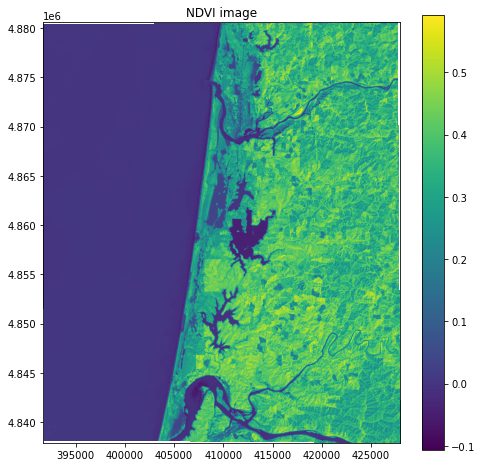

In [79]:
# Plot NDVI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndvi, extent=full_extent)
ax.set_title("NDVI image")
fig.colorbar(im, orientation='vertical')
plt.show()

In [74]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,4],all_bands_image[:,:,3],all_bands_image[:,:,2]))

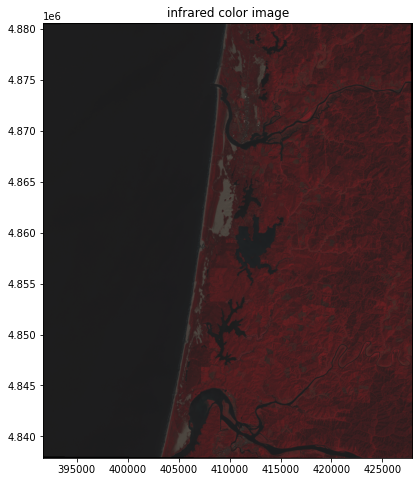

In [75]:
# Plot as infrared image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("infrared color image")
plt.show()